<a href="https://colab.research.google.com/github/marco-siino/bci-gpt/blob/main/BCI_Competition_IV2a_Signal_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/marco-siino/bci-gpt.git
%cd bci-gpt

Cloning into 'bci-gpt'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 33 (delta 13), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (33/33), 75.94 KiB | 589.00 KiB/s, done.
Resolving deltas: 100% (13/13), done.
/content/bci-gpt


In [3]:
"""
CTNet: A Convolution-Transformer Network for EEG-Based Motor Imagery Classification

author: zhaowei701@163.com

"""

!pip install mne

import os
gpus = [0]
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import numpy as np
import pandas as pd
import random
import datetime
import time

from pandas import ExcelWriter
from torchsummary import summary
import torch
from torch.backends import cudnn
from utils import calMetrics
from utils import calculatePerClass
from utils import numberClassChannel
import math
import warnings
warnings.filterwarnings("ignore")
cudnn.benchmark = False
cudnn.deterministic = True



import torch
from torch import nn
from torch import Tensor
from einops.layers.torch import Rearrange, Reduce
from einops import rearrange, reduce, repeat
import torch.nn.functional as F

from utils import numberClassChannel
from utils import load_data_evaluate

import numpy as np
import pandas as pd
from torch.autograd import Variable

import mne
import numpy as np
import scipy.signal as signal
from scipy.io import savemat
import scipy.io as sio
import numpy as np

In [4]:
!wget -O BCICIV_2a_gdf.zip https://www.bbci.de/competition/download/competition_iv/BCICIV_2a_gdf.zip


--2025-02-10 07:56:19--  https://www.bbci.de/competition/download/competition_iv/BCICIV_2a_gdf.zip
Resolving www.bbci.de (www.bbci.de)... 130.149.80.149
Connecting to www.bbci.de (www.bbci.de)|130.149.80.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 439968864 (420M) [application/zip]
Saving to: ‘BCICIV_2a_gdf.zip’

BCICIV_2a_gdf.zip   100%[===================>] 419.59M  22.0MB/s    in 21s     

2025-02-10 07:56:40 (20.3 MB/s) - ‘BCICIV_2a_gdf.zip’ saved [439968864/439968864]



In [5]:
!unzip BCICIV_2a_gdf.zip -d ./BCICIV_2a_gdf/


Archive:  BCICIV_2a_gdf.zip
  inflating: ./BCICIV_2a_gdf/A01E.gdf  
  inflating: ./BCICIV_2a_gdf/A01T.gdf  
  inflating: ./BCICIV_2a_gdf/A02E.gdf  
  inflating: ./BCICIV_2a_gdf/A02T.gdf  
  inflating: ./BCICIV_2a_gdf/A03E.gdf  
  inflating: ./BCICIV_2a_gdf/A03T.gdf  
  inflating: ./BCICIV_2a_gdf/A04E.gdf  
  inflating: ./BCICIV_2a_gdf/A04T.gdf  
  inflating: ./BCICIV_2a_gdf/A05E.gdf  
  inflating: ./BCICIV_2a_gdf/A05T.gdf  
  inflating: ./BCICIV_2a_gdf/A06E.gdf  
  inflating: ./BCICIV_2a_gdf/A06T.gdf  
  inflating: ./BCICIV_2a_gdf/A07E.gdf  
  inflating: ./BCICIV_2a_gdf/A07T.gdf  
  inflating: ./BCICIV_2a_gdf/A08E.gdf  
  inflating: ./BCICIV_2a_gdf/A08T.gdf  
  inflating: ./BCICIV_2a_gdf/A09E.gdf  
  inflating: ./BCICIV_2a_gdf/A09T.gdf  


In [10]:
# Scaricare il file con wget
!wget -O A01T.mat "https://bnci-horizon-2020.eu/database/data-sets/001-2014/A01T.mat"

# Importare scipy per leggere il file MAT
import scipy.io

# Caricare il file MAT
data = scipy.io.loadmat("A01T.mat")

# Visualizzare le chiavi principali del file MAT
print(data.keys())


--2025-02-10 08:06:49--  https://bnci-horizon-2020.eu/database/data-sets/001-2014/A01T.mat
Resolving bnci-horizon-2020.eu (bnci-horizon-2020.eu)... 91.227.205.222, 2a03:f80:ad15:91:227:205:222:1
Connecting to bnci-horizon-2020.eu (bnci-horizon-2020.eu)|91.227.205.222|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://lampx.tugraz.at/~bci/database/001-2014/A01T.mat [following]
--2025-02-10 08:06:50--  https://lampx.tugraz.at/~bci/database/001-2014/A01T.mat
Resolving lampx.tugraz.at (lampx.tugraz.at)... 129.27.124.233
Connecting to lampx.tugraz.at (lampx.tugraz.at)|129.27.124.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42806453 (41M)
Saving to: ‘A01T.mat’

A01T.mat            100%[===================>]  40.82M  12.9MB/s    in 3.2s    

2025-02-10 08:06:54 (12.9 MB/s) - ‘A01T.mat’ saved [42806453/42806453]

dict_keys(['__header__', '__version__', '__globals__', 'data'])


In [11]:
"""
# Function: Read files and preprocess them
# Steps:
# 1. Import data from the gdf file provided before the competition,
#    remove unwanted channels, and select required events.
# 2. Select desired time segments for slicing; treat each segment (4s) as one sample.
# 3. Import labels from the mat file provided after the competition,
#    ensuring they correspond with epochs and their numbers match.
# 4. Save the resulting data in a new mat file,
#    preparing it for use in the subsequent main.py.
"""

def changeGdf2Mat(dir_path, mode="train"):
    '''
    read data from GDF files and store as mat files

    Parameters
    ----------
    dir_path : str
        GDF file dir path.
    mode : str, optional
        change train dataset or eval dataset. The default is "train".

    Returns
    -------
    None.

    '''
    mode_str = ''
    if mode=="train":
        mode_str = 'T'
    else:
        mode_str = 'E'
    for nSub in range(1, 10):
        # Load the gdf file
        data_filename = dir_path+'BCICIV_2a_gdf/A0{}{}.gdf'.format(nSub, mode_str)
        raw = mne.io.read_raw_gdf(data_filename)

        # Select the events of interest
        events, event_dict = mne.events_from_annotations(raw)
        if mode=="train":
            # train dataset are labeled
            event_id = {'Left': event_dict['769'],
                        'Right': event_dict['770'],
                        'Foot': event_dict['771'],
                        'Tongue': event_dict['772']}
        else:
            # evaluate dataset are labeled as 'Unknnow'
            event_id = {'Unknown': event_dict['783']}

        # Select the events corresponding to the four categories we are interested in. Here, events[:, 2] refers to the third column of the events array, which represents the event IDs.
        selected_events = events[np.isin(events[:, 2], list(event_id.values()))]

        # remove EOG channels
        raw.info['bads'] += ['EOG-left', 'EOG-central', 'EOG-right']
        picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False, exclude='bads')
        # Epoch the data
        # using 4s (1000 sample point ) segmentation
        epochs = mne.Epochs(raw, selected_events, event_id, picks=picks,tmin=0, tmax=3.996, preload=True, baseline=None)

        filtered_data = epochs.get_data()
        label_filename = 'true_labels/'+'A0{}{}.mat'.format(nSub, mode_str)
        mat = sio.loadmat(label_filename)  # load target mat file
        labels = mat['classlabel']

        # Save the data and labels to a .mat file
        result_filename = 'mymat_raw/A0{}{}.mat'.format(nSub, mode_str)
        savemat(result_filename, {'data': filtered_data, 'label': labels})

dir_path = './'
# prepare train dataset
changeGdf2Mat(dir_path, 'train')
# prepare test dataset
changeGdf2Mat(dir_path, 'eval')

Extracting EDF parameters from /content/bci-gpt/BCICIV_2a_gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 1000 original time points ...
0 bad epochs dropped


KeyError: 'classlabel'

In [24]:
import mne

# Caricare il file GDF
gdf_file = "/content/bci-gpt/BCICIV_2a_gdf/A01T.gdf"
raw = mne.io.read_raw_gdf(gdf_file, preload=True)

# Stampare le informazioni generali
print(raw.info)


Extracting EDF parameters from /content/bci-gpt/BCICIV_2a_gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: EEG-Fz, EEG-0, EEG-1, EEG-2, EEG-3, EEG-4, EEG-5, EEG-C3, EEG-6, ...
 chs: 25 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 2005-01-17 12:00:00 UTC
 nchan: 25
 projs: []
 sfreq: 250.0 Hz
 subject_info: <subject_info | his_id: A01, sex: 0, last_name: X, birthday: 1983-01-17>
>


Canali EEG: ['EEG-Fz', 'EEG-0', 'EEG-1', 'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5', 'EEG-C3', 'EEG-6', 'EEG-Cz', 'EEG-7', 'EEG-C4', 'EEG-8', 'EEG-9', 'EEG-10', 'EEG-11', 'EEG-12', 'EEG-13', 'EEG-14', 'EEG-Pz', 'EEG-15', 'EEG-16', 'EOG-left', 'EOG-central', 'EOG-right']


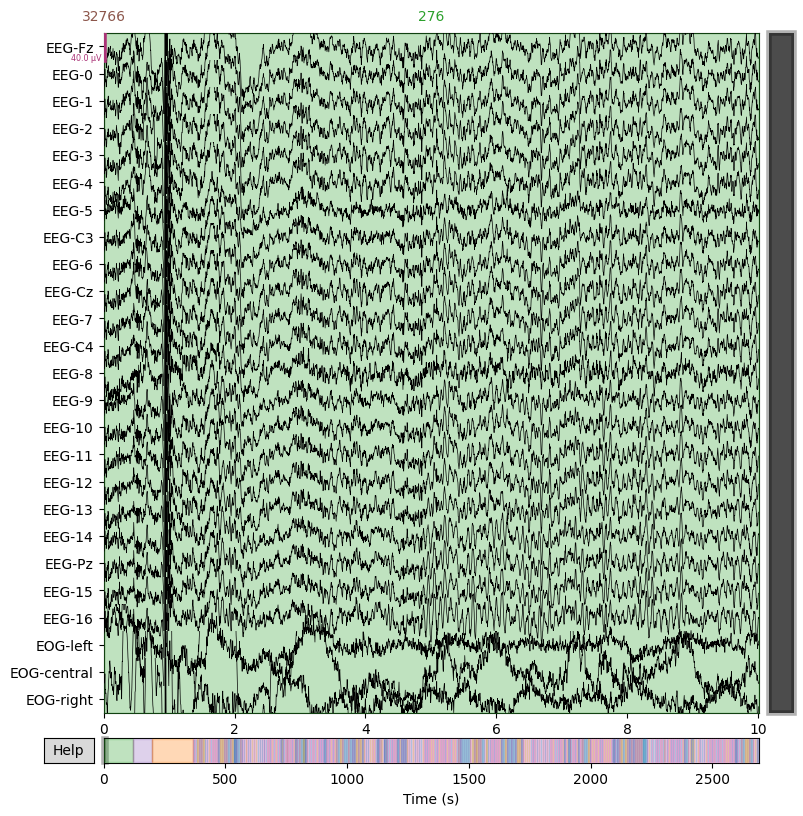

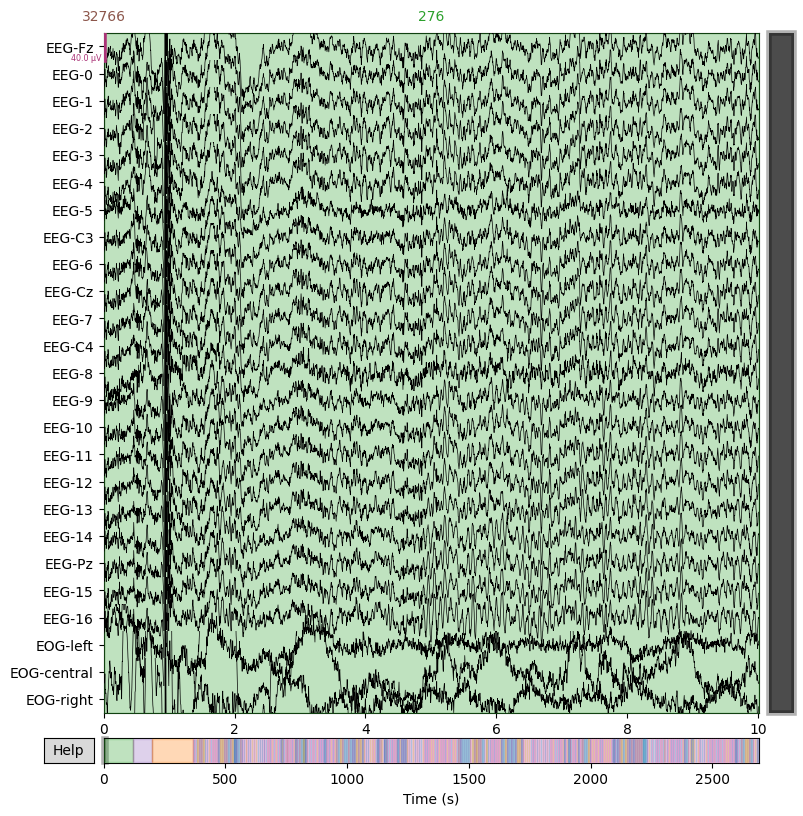

In [32]:
# Stampare i nomi dei canali
print("Canali EEG:", raw.ch_names)

# Tracciare un grafico del segnale EEG
raw.plot(duration=10, n_channels=30)


In [27]:
# Estrarre gli eventi (stimoli BCI)
events, event_id = mne.events_from_annotations(raw)

# Stampare la lista degli eventi
print("Eventi trovati:", events[:20])  # Mostra i primi 10 eventi
print("Mappatura eventi:", event_id)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Eventi trovati: [[     0      0      5]
 [     0      0      3]
 [ 29683      0      5]
 [ 29683      0      4]
 [ 49955      0      5]
 [ 49955      0      2]
 [ 91518      0      5]
 [ 91868      0      6]
 [ 92368      0     10]
 [ 93871      0      6]
 [ 94371      0      9]
 [ 95789      0      6]
 [ 96289      0      8]
 [ 97741      0      6]
 [ 98241      0      7]
 [ 99749      0      6]
 [100249      0      7]
 [101860      0      6]
 [102360      0      8]
 [103777      0      6]]
Mappatura eventi: {'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}


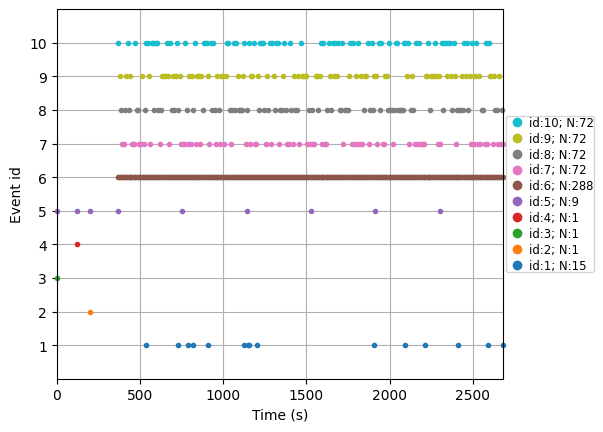

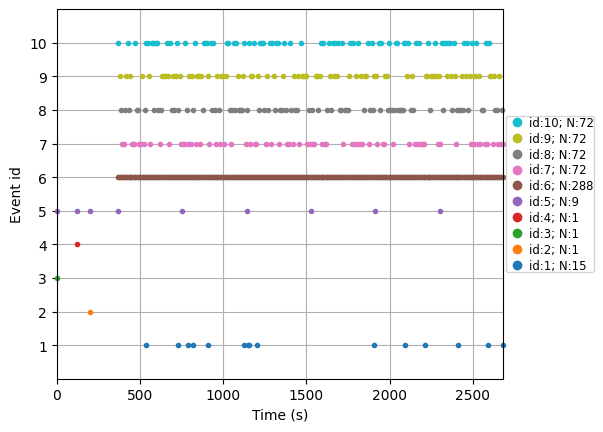

In [28]:
# Visualizzare gli eventi su un grafico
mne.viz.plot_events(events, raw.info['sfreq'])


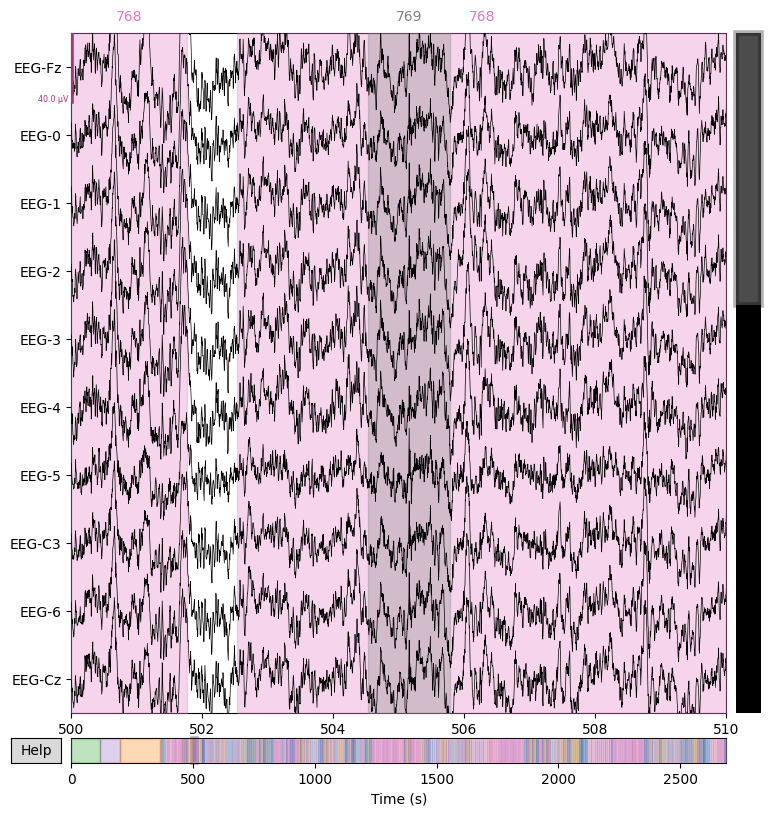

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']


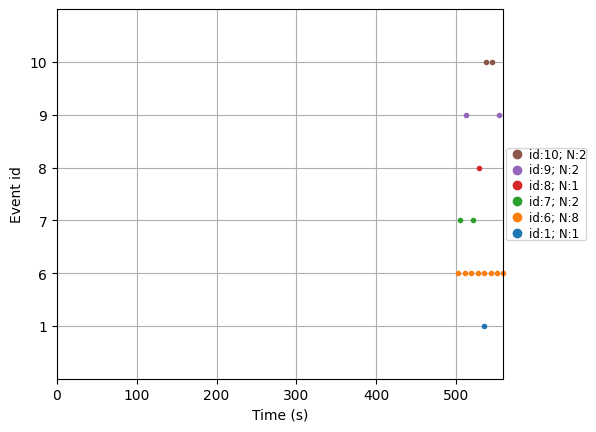

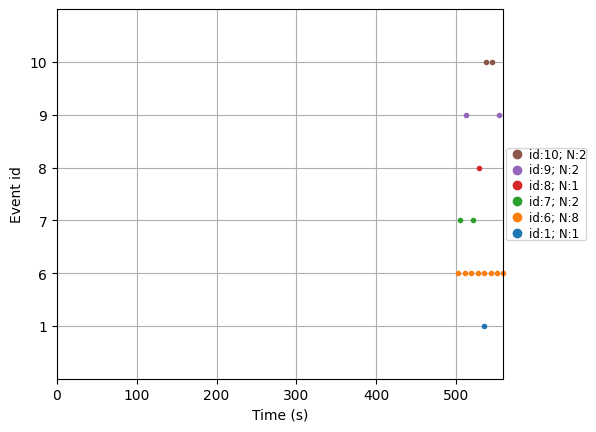

In [38]:
# Calcolare il range di campioni da 500 a 510 secondi
start_time = 500  # in secondi
end_time = 560    # in secondi

start_sample = int(start_time * sfreq)
end_sample = int(end_time * sfreq)

# Tracciare i dati EEG tra i secondi 500 e 510
raw.plot(start=start_time, duration=10, n_channels=10)

# (Opzionale) Filtrare gli eventi in questo intervallo di tempo
events, _ = mne.events_from_annotations(raw)
events_in_window = events[(events[:, 0] >= start_sample) & (events[:, 0] <= end_sample)]

# Visualizzare gli eventi nel periodo da 500 a 510 secondi
mne.viz.plot_events(events_in_window, sfreq)

La matrice che vedi è un array di eventi, e ciascuna riga rappresenta un evento con tre colonne:

[[time_sample, _, event_id],
 [time_sample, _, event_id],
 ...
]



In [34]:
# Stampare gli eventi per vedere se esistono e a che tempi sono associati
print(events[:10])  # Stampa i primi 10 eventi


[[    0     0     5]
 [    0     0     3]
 [29683     0     5]
 [29683     0     4]
 [49955     0     5]
 [49955     0     2]
 [91518     0     5]
 [91868     0     6]
 [92368     0    10]
 [93871     0     6]]


In [35]:
# Frequenza di campionamento (modifica con la tua specifica)
sfreq = raw.info['sfreq']

# Calcolare il range di campioni da 10 a 12 secondi
start_sample = int(10 * sfreq)
end_sample = int(12 * sfreq)

# Filtrare gli eventi per il range di tempo
events_in_window = events[(events[:, 0] >= start_sample) & (events[:, 0] <= end_sample)]

# Visualizzare gli eventi trovati nel range
print(events_in_window)

# Tracciare gli eventi nel periodo da 10 a 12 secondi
mne.viz.plot_events(events_in_window, raw.info['sfreq'])


[]


ValueError: No events in events array, cannot plot.

In [29]:
# Estrarre dati EEG in formato numpy
eeg_data, times = raw[:10, :1000]  # Primi 10 canali, primi 1000 campioni

print("Forma dei dati EEG:", eeg_data.shape)
print("Primi 5 valori del primo canale:", eeg_data[0, :5])


Forma dei dati EEG: (10, 1000)
Primi 5 valori del primo canale: [-2.11425781e-05 -2.19238281e-05 -1.56250000e-05 -1.66992188e-05
 -1.93359375e-05]


In [ ]:
class PatchEmbeddingCNN(nn.Module):
    def __init__(self, f1=16, kernel_size=64, D=2, pooling_size1=8, pooling_size2=8, dropout_rate=0.3, number_channel=22, emb_size=40):
        super().__init__()
        f2 = D*f1
        self.cnn_module = nn.Sequential(
            # temporal conv kernel size 64=0.25fs
            nn.Conv2d(1, f1, (1, kernel_size), (1, 1), padding='same', bias=False), # [batch, 22, 1000]
            nn.BatchNorm2d(f1),
            # channel depth-wise conv
            nn.Conv2d(f1, f2, (number_channel, 1), (1, 1), groups=f1, padding='valid', bias=False), #
            nn.BatchNorm2d(f2),
            nn.ELU(),
            # average pooling 1
            nn.AvgPool2d((1, pooling_size1)),  # pooling acts as slicing to obtain 'patch' along the time dimension as in ViT
            nn.Dropout(dropout_rate),
            # spatial conv
            nn.Conv2d(f2, f2, (1, 16), padding='same', bias=False),
            nn.BatchNorm2d(f2),
            nn.ELU(),

            # average pooling 2 to adjust the length of feature into transformer encoder
            nn.AvgPool2d((1, pooling_size2)),
            nn.Dropout(dropout_rate),

        )

        self.projection = nn.Sequential(
            Rearrange('b e (h) (w) -> b (h w) e'),
        )


    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.cnn_module(x)
        x = self.projection(x)
        return x




class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads, dropout):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x: Tensor, mask: Tensor = None) -> Tensor:
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1 / 2)
        att = F.softmax(energy / scaling, dim=-1)
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out



# PointWise FFN
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion, drop_p):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )



class ClassificationHead(nn.Sequential):
    def __init__(self, flatten_number, n_classes):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(flatten_number, n_classes)
        )

    def forward(self, x):
        out = self.fc(x)

        return out


class ResidualAdd(nn.Module):
    def __init__(self, fn, emb_size, drop_p):
        super().__init__()
        self.fn = fn
        self.drop = nn.Dropout(drop_p)
        self.layernorm = nn.LayerNorm(emb_size)

    def forward(self, x, **kwargs):
        x_input = x
        res = self.fn(x, **kwargs)

        out = self.layernorm(self.drop(res)+x_input)
        return out

class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size,
                 num_heads=4,
                 drop_p=0.5,
                 forward_expansion=4,
                 forward_drop_p=0.5):
        super().__init__(
            ResidualAdd(nn.Sequential(
                MultiHeadAttention(emb_size, num_heads, drop_p),
                ), emb_size, drop_p),
            ResidualAdd(nn.Sequential(
                FeedForwardBlock(emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                ), emb_size, drop_p)

            )


class TransformerEncoder(nn.Sequential):
    def __init__(self, heads, depth, emb_size):
        super().__init__(*[TransformerEncoderBlock(emb_size, heads) for _ in range(depth)])




class BranchEEGNetTransformer(nn.Sequential):
    def __init__(self, heads=4,
                 depth=6,
                 emb_size=40,
                 number_channel=22,
                 f1 = 20,
                 kernel_size = 64,
                 D = 2,
                 pooling_size1 = 8,
                 pooling_size2 = 8,
                 dropout_rate = 0.3,
                 **kwargs):
        super().__init__(
            PatchEmbeddingCNN(f1=f1,
                                 kernel_size=kernel_size,
                                 D=D,
                                 pooling_size1=pooling_size1,
                                 pooling_size2=pooling_size2,
                                 dropout_rate=dropout_rate,
                                 number_channel=number_channel,
                                 emb_size=emb_size),
#             TransformerEncoder(heads, depth, emb_size),
        )






class PositioinalEncoding(nn.Module):
    def __init__(self, embedding, length=100, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.encoding = nn.Parameter(torch.randn(1, length, embedding))
    def forward(self, x): # x-> [batch, embedding, length]
        x = x + self.encoding[:, :x.shape[1], :].cuda()
        return self.dropout(x)






class EEGTransformer(nn.Module):
    def __init__(self, heads=4,
                 emb_size=40,
                 depth=6,
                 database_type='A',
                 eeg1_f1 = 20,
                 eeg1_kernel_size = 64,
                 eeg1_D = 2,
                 eeg1_pooling_size1 = 8,
                 eeg1_pooling_size2 = 8,
                 eeg1_dropout_rate = 0.3,
                 eeg1_number_channel = 22,
                 flatten_eeg1 = 600,
                 **kwargs):
        super().__init__()
        self.number_class, self.number_channel = numberClassChannel(database_type)
        self.emb_size = emb_size
        self.flatten_eeg1 = flatten_eeg1
        self.flatten = nn.Flatten()
        # print('self.number_channel', self.number_channel)
        self.cnn = BranchEEGNetTransformer(heads, depth, emb_size, number_channel=self.number_channel,
                                              f1 = eeg1_f1,
                                              kernel_size = eeg1_kernel_size,
                                              D = eeg1_D,
                                              pooling_size1 = eeg1_pooling_size1,
                                              pooling_size2 = eeg1_pooling_size2,
                                              dropout_rate = eeg1_dropout_rate,
                                              )
        self.position = PositioinalEncoding(emb_size, dropout=0.1)
        self.trans = TransformerEncoder(heads, depth, emb_size)
#         self.drop = nn.Dropout(0.5)


        # self.cnn_module = Branchcnn_moduleTransformer(heads, depth, emb_size)
        self.flatten = nn.Flatten()
        self.classification = ClassificationHead(self.flatten_eeg1 , self.number_class) # FLATTEN_EEGNet + FLATTEN_cnn_module
    def forward(self, x):
        cnn = self.cnn(x)

        # add label
        cnn = cnn * math.sqrt(self.emb_size)
        cnn = self.position(cnn)

        trans = self.trans(cnn)

        features = cnn+trans


        out = self.classification(self.flatten(features))
        return features, out


class ExP():
    def __init__(self, nsub, data_dir, result_name,
                 epochs=2000,
                 number_aug=2,
                 number_seg=8,
                 gpus=[0],
                 evaluate_mode = 'subject-dependent',
                 heads=4,
                 emb_size=40,
                 depth=6,
                 dataset_type='A',
                 eeg1_f1 = 20,
                 eeg1_kernel_size = 64,
                 eeg1_D = 2,
                 eeg1_pooling_size1 = 8,
                 eeg1_pooling_size2 = 8,
                 eeg1_dropout_rate = 0.3,
                 flatten_eeg1 = 600,
                 validate_ratio = 0.2,
                 learning_rate = 0.001,
                 batch_size = 72,
                 ):

        super(ExP, self).__init__()
        self.dataset_type = dataset_type
        self.batch_size = batch_size
        self.lr = learning_rate
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_epochs = epochs
        self.nSub = nsub
        self.number_augmentation = number_aug
        self.number_seg = number_seg
        self.root = data_dir
        self.heads=heads
        self.emb_size=emb_size
        self.depth=depth
        self.result_name = result_name
        self.evaluate_mode = evaluate_mode
        self.validate_ratio = validate_ratio

        self.Tensor = torch.cuda.FloatTensor
        self.LongTensor = torch.cuda.LongTensor
        self.criterion_cls = torch.nn.CrossEntropyLoss().cuda()

        self.number_class, self.number_channel = numberClassChannel(self.dataset_type)
        self.model = EEGTransformer(
             heads=self.heads,
             emb_size=self.emb_size,
             depth=self.depth,
            database_type=self.dataset_type,
            eeg1_f1=eeg1_f1,
            eeg1_D=eeg1_D,
            eeg1_kernel_size=eeg1_kernel_size,
            eeg1_pooling_size1 = eeg1_pooling_size1,
            eeg1_pooling_size2 = eeg1_pooling_size2,
            eeg1_dropout_rate = eeg1_dropout_rate,
            eeg1_number_channel = self.number_channel,
            flatten_eeg1 = flatten_eeg1,
            ).cuda()
        #self.model = nn.DataParallel(self.model, device_ids=gpus)
        self.model = self.model.cuda()
        self.model_filename = self.result_name + '/model_{}.pth'.format(self.nSub)

    # Segmentation and Reconstruction (S&R) data augmentation
    def interaug(self, timg, label):
        aug_data = []
        aug_label = []
        number_records_by_augmentation = self.number_augmentation * int(self.batch_size / self.number_class)
        number_segmentation_points = 1000 // self.number_seg
        for clsAug in range(self.number_class):
            cls_idx = np.where(label == clsAug + 1)
            tmp_data = timg[cls_idx]
            tmp_label = label[cls_idx]

            tmp_aug_data = np.zeros((number_records_by_augmentation, 1, self.number_channel, 1000))
            for ri in range(number_records_by_augmentation):
                for rj in range(self.number_seg):
                    rand_idx = np.random.randint(0, tmp_data.shape[0], self.number_seg)
                    tmp_aug_data[ri, :, :, rj * number_segmentation_points:(rj + 1) * number_segmentation_points] = \
                        tmp_data[rand_idx[rj], :, :, rj * number_segmentation_points:(rj + 1) * number_segmentation_points]

            aug_data.append(tmp_aug_data)
            aug_label.append(tmp_label[:number_records_by_augmentation])
        aug_data = np.concatenate(aug_data)
        aug_label = np.concatenate(aug_label)
        aug_shuffle = np.random.permutation(len(aug_data))
        aug_data = aug_data[aug_shuffle, :, :]
        aug_label = aug_label[aug_shuffle]

        aug_data = torch.from_numpy(aug_data).cuda()
        aug_data = aug_data.float()
        aug_label = torch.from_numpy(aug_label-1).cuda()
        aug_label = aug_label.long()
        return aug_data, aug_label



    def get_source_data(self):
        (self.train_data,    # (batch, channel, length)
         self.train_label,
         self.test_data,
         self.test_label) = load_data_evaluate(self.root, self.dataset_type, self.nSub, mode_evaluate=self.evaluate_mode)

        self.train_data = np.expand_dims(self.train_data, axis=1)  # (288, 1, 22, 1000)
        self.train_label = np.transpose(self.train_label)

        self.allData = self.train_data
        self.allLabel = self.train_label[0]

        shuffle_num = np.random.permutation(len(self.allData))
        # print("len(self.allData):", len(self.allData))
        self.allData = self.allData[shuffle_num, :, :, :]  # (288, 1, 22, 1000)
        # print("shuffle_num", shuffle_num)
        # print("self.allLabel", self.allLabel)
        self.allLabel = self.allLabel[shuffle_num]


        print('-'*20, "train size：", self.train_data.shape, "test size：", self.test_data.shape)
        # self.test_data = np.transpose(self.test_data, (2, 1, 0))
        self.test_data = np.expand_dims(self.test_data, axis=1)
        self.test_label = np.transpose(self.test_label)

        self.testData = self.test_data
        self.testLabel = self.test_label[0]


        # standardize
        target_mean = np.mean(self.allData)
        target_std = np.std(self.allData)
        self.allData = (self.allData - target_mean) / target_std
        self.testData = (self.testData - target_mean) / target_std

        isSaveDataLabel = False #True
        if isSaveDataLabel:
            np.save("./gradm_data/train_data_{}.npy".format(self.nSub), self.allData)
            np.save("./gradm_data/train_lable_{}.npy".format(self.nSub), self.allLabel)
            np.save("./gradm_data/test_data_{}.npy".format(self.nSub), self.testData)
            np.save("./gradm_data/test_label_{}.npy".format(self.nSub), self.testLabel)


        # data shape: (trial, conv channel, electrode channel, time samples)
        return self.allData, self.allLabel, self.testData, self.testLabel


    def train(self):
        img, label, test_data, test_label = self.get_source_data()
        # print("label size:", label.shape)
        # print("label size:", label)

        img = torch.from_numpy(img)
        label = torch.from_numpy(label - 1)
        dataset = torch.utils.data.TensorDataset(img, label)


        test_data = torch.from_numpy(test_data)
        test_label = torch.from_numpy(test_label - 1)
        test_dataset = torch.utils.data.TensorDataset(test_data, test_label)
        self.test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=self.batch_size, shuffle=False)

        # Optimizers
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, betas=(self.b1, self.b2))

        test_data = Variable(test_data.type(self.Tensor))
        test_label = Variable(test_label.type(self.LongTensor))
        best_epoch = 0
        num = 0
        min_loss = 100
        # recording train_acc, train_loss, test_acc, test_loss
        result_process = []
        # Train the cnn model
        for e in range(self.n_epochs):
            self.dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=self.batch_size, shuffle=True)
            epoch_process = {}
            epoch_process['epoch'] = e
            # in_epoch = time.time()
            self.model.train()
            outputs_list = []
            label_list = []
            # 验证集
            val_data_list = []
            val_label_list = []
            for i, (img, label) in enumerate(self.dataloader):
                number_sample = img.shape[0]
                number_validate = int(self.validate_ratio * number_sample)

                # split raw train dataset into real train dataset and validate dataset
                train_data = img[:-number_validate]
                train_label = label[:-number_validate]

                val_data_list.append(img[number_validate:])
                val_label_list.append(label[number_validate:])

                # real train dataset
                img = Variable(train_data.type(self.Tensor))
                label = Variable(train_label.type(self.LongTensor))

                # data augmentation
                aug_data, aug_label = self.interaug(self.allData, self.allLabel)
                # concat real train dataset and generate aritifical train dataset
                img = torch.cat((img, aug_data))
                label = torch.cat((label, aug_label))

                # training model
                features, outputs = self.model(img)
                outputs_list.append(outputs)
                label_list.append(label)
                # print("train outputs: ", outputs.shape, type(outputs))
                # print(features.size())
                loss = self.criterion_cls(outputs, label)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            del img
            torch.cuda.empty_cache()
            # out_epoch = time.time()
            # test process
            if (e + 1) % 1 == 0:
                self.model.eval()
                # validate model
                val_data = torch.cat(val_data_list).cuda()
                val_label = torch.cat(val_label_list).cuda()
                val_data = val_data.type(self.Tensor)
                val_label = val_label.type(self.LongTensor)

                val_dataset = torch.utils.data.TensorDataset(val_data, val_label)
                self.val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=self.batch_size, shuffle=False)
                outputs_list = []
                with torch.no_grad():
                    for i, (img, _) in enumerate(self.val_dataloader):
                        # val model
                        img = img.type(self.Tensor).cuda()
                        _, Cls = self.model(img)
                        outputs_list.append(Cls)
                        del img, Cls
                        torch.cuda.empty_cache()

                Cls = torch.cat(outputs_list)

                val_loss = self.criterion_cls(Cls, val_label)
                val_pred = torch.max(Cls, 1)[1]
                val_acc = float((val_pred == val_label).cpu().numpy().astype(int).sum()) / float(val_label.size(0))

                epoch_process['val_acc'] = val_acc
                epoch_process['val_loss'] = val_loss.detach().cpu().numpy()

                train_pred = torch.max(outputs, 1)[1]
                train_acc = float((train_pred == label).cpu().numpy().astype(int).sum()) / float(label.size(0))
                epoch_process['train_acc'] = train_acc
                epoch_process['train_loss'] = loss.detach().cpu().numpy()

                num = num + 1

                # if min_loss>val_loss:
                if min_loss>val_loss:
                    min_loss = val_loss
                    best_epoch = e
                    epoch_process['epoch'] = e
                    torch.save(self.model, self.model_filename)
                    print("{}_{} train_acc: {:.4f} train_loss: {:.6f}\tval_acc: {:.6f} val_loss: {:.7f}".format(self.nSub,
                                                                                           epoch_process['epoch'],
                                                                                           epoch_process['train_acc'],
                                                                                           epoch_process['train_loss'],
                                                                                           epoch_process['val_acc'],
                                                                                           epoch_process['val_loss'],
                                                                                        ))


            result_process.append(epoch_process)


            del label, val_data, val_label
            torch.cuda.empty_cache()

        # load model for test
        self.model.eval()
        self.model = torch.load(self.model_filename).cuda()
        outputs_list = []
        with torch.no_grad():
            for i, (img, label) in enumerate(self.test_dataloader):
                img_test = Variable(img.type(self.Tensor)).cuda()
                # label_test = Variable(label.type(self.LongTensor))

                # test model
                features, outputs = self.model(img_test)
                val_pred = torch.max(outputs, 1)[1]
                outputs_list.append(outputs)
        outputs = torch.cat(outputs_list)
        y_pred = torch.max(outputs, 1)[1]


        test_acc = float((y_pred == test_label).cpu().numpy().astype(int).sum()) / float(test_label.size(0))

        print("epoch: ", best_epoch, '\tThe test accuracy is:', test_acc)


        df_process = pd.DataFrame(result_process)

        return test_acc, test_label, y_pred, df_process, best_epoch
        # writer.close()







In [ ]:
def main(dirs,
         evaluate_mode = 'subject-dependent', # 评估模式：LOSO（跨个体）或其他（subject-dependent, subject-specific），
         heads=8,             # heads of MHA
         emb_size=48,         # token embding dim
         depth=3,             # Transformer encoder depth
         dataset_type='A',    # A->'BCI IV2a', B->'BCI IV2b'
         eeg1_f1=20,          # features of temporal conv
         eeg1_kernel_size=64, # kernel size of temporal conv
         eeg1_D=2,            # depth-wise conv
         eeg1_pooling_size1=8,# p1
         eeg1_pooling_size2=8,# p2
         eeg1_dropout_rate=0.3,
         flatten_eeg1=600,
         validate_ratio = 0.2
         ):

    if not os.path.exists(dirs):
        os.makedirs(dirs)

    result_write_metric = ExcelWriter(dirs+"/result_metric.xlsx")

    result_metric_dict = {}
    y_true_pred_dict = { }

    process_write = ExcelWriter(dirs+"/process_train.xlsx")
    pred_true_write = ExcelWriter(dirs+"/pred_true.xlsx")
    subjects_result = []
    best_epochs = []

    for i in range(N_SUBJECT):

        starttime = datetime.datetime.now()
        seed_n = np.random.randint(2024)
        print('seed is ' + str(seed_n))
        random.seed(seed_n)
        np.random.seed(seed_n)
        torch.manual_seed(seed_n)
        torch.cuda.manual_seed(seed_n)
        torch.cuda.manual_seed_all(seed_n)
        index_round =0
        print('Subject %d' % (i+1))
        exp = ExP(i + 1, DATA_DIR, dirs, EPOCHS, N_AUG, N_SEG, gpus,
                  evaluate_mode = evaluate_mode,
                  heads=heads,
                  emb_size=emb_size,
                  depth=depth,
                  dataset_type=dataset_type,
                  eeg1_f1 = eeg1_f1,
                  eeg1_kernel_size = eeg1_kernel_size,
                  eeg1_D = eeg1_D,
                  eeg1_pooling_size1 = eeg1_pooling_size1,
                  eeg1_pooling_size2 = eeg1_pooling_size2,
                  eeg1_dropout_rate = eeg1_dropout_rate,
                  flatten_eeg1 = flatten_eeg1,
                  validate_ratio = validate_ratio
                  )

        testAcc, Y_true, Y_pred, df_process, best_epoch = exp.train()
        true_cpu = Y_true.cpu().numpy().astype(int)
        pred_cpu = Y_pred.cpu().numpy().astype(int)
        df_pred_true = pd.DataFrame({'pred': pred_cpu, 'true': true_cpu})
        df_pred_true.to_excel(pred_true_write, sheet_name=str(i+1))
        y_true_pred_dict[i] = df_pred_true

        accuracy, precison, recall, f1, kappa = calMetrics(true_cpu, pred_cpu)
        subject_result = {'accuray': accuracy*100,
                          'precision': precison*100,
                          'recall': recall*100,
                          'f1': f1*100,
                          'kappa': kappa*100
                          }
        subjects_result.append(subject_result)
        df_process.to_excel(process_write, sheet_name=str(i+1))
        best_epochs.append(best_epoch)

        print(' THE BEST ACCURACY IS ' + str(testAcc) + "\tkappa is " + str(kappa) )


        endtime = datetime.datetime.now()
        print('subject %d duration: '%(i+1) + str(endtime - starttime))

        if i == 0:
            yt = Y_true
            yp = Y_pred
        else:
            yt = torch.cat((yt, Y_true))
            yp = torch.cat((yp, Y_pred))

        df_result = pd.DataFrame(subjects_result)
    process_write.close()
    pred_true_write.close()


    print('**The average Best accuracy is: ' + str(df_result['accuray'].mean()) + "kappa is: " + str(df_result['kappa'].mean()) + "\n" )
    print("best epochs: ", best_epochs)
    #df_result.to_excel(result_write_metric, index=False)
    result_metric_dict = df_result

    mean = df_result.mean(axis=0)
    mean.name = 'mean'
    std = df_result.std(axis=0)
    std.name = 'std'
    df_result = pd.concat([df_result, pd.DataFrame(mean).T, pd.DataFrame(std).T])

    df_result.to_excel(result_write_metric, index=False)
    print('-'*9, ' all result ', '-'*9)
    print(df_result)

    print("*"*40)

    result_write_metric.close()


    return result_metric_dict

if __name__ == "__main__":
    #----------------------------------------
    DATA_DIR = r'../mymat_raw/'
    EVALUATE_MODE = 'LOSO-No' # leaving one subject out subject-dependent  subject-indenpedent

    N_SUBJECT = 9       # BCI
    N_AUG = 3           # data augmentation times for benerating artificial training data set
    N_SEG = 8           # segmentation times for S&R

    EPOCHS = 1000
    EMB_DIM = 16
    HEADS = 2
    DEPTH = 6
    TYPE = 'B'
    validate_ratio = 0.3 # split raw train dataset into real train dataset and validate dataset

    EEGNet1_F1 = 8
    EEGNet1_KERNEL_SIZE=64
    EEGNet1_D=2
    EEGNet1_POOL_SIZE1 = 8
    EEGNet1_POOL_SIZE2 = 8
    FLATTEN_EEGNet1 = 240

    if EVALUATE_MODE!='LOSO':
        EEGNet1_DROPOUT_RATE = 0.5
    else:
        EEGNet1_DROPOUT_RATE = 0.25


    parameters_list = ['A']
    for TYPE in parameters_list:
        number_class, number_channel = numberClassChannel(TYPE)
        RESULT_NAME = "CTNet_{}_heads_{}_depth_{}_{}".format(TYPE, HEADS, DEPTH, int(time.time()))

        sModel = EEGTransformer(
            heads=HEADS,
            emb_size=EMB_DIM,
            depth=DEPTH,
            database_type=TYPE,
            eeg1_f1=EEGNet1_F1,
            eeg1_D=EEGNet1_D,
            eeg1_kernel_size=EEGNet1_KERNEL_SIZE,
            eeg1_pooling_size1 = EEGNet1_POOL_SIZE1,
            eeg1_pooling_size2 = EEGNet1_POOL_SIZE2,
            eeg1_dropout_rate = EEGNet1_DROPOUT_RATE,
            eeg1_number_channel = number_channel,
            flatten_eeg1 = FLATTEN_EEGNet1,
            ).cuda()
        summary(sModel, (1, number_channel, 1000))

        print(time.asctime(time.localtime(time.time())))

        result = main(RESULT_NAME,
                        evaluate_mode = EVALUATE_MODE,
                        heads=HEADS,
                        emb_size=EMB_DIM,
                        depth=DEPTH,
                        dataset_type=TYPE,
                        eeg1_f1 = EEGNet1_F1,
                        eeg1_kernel_size = EEGNet1_KERNEL_SIZE,
                        eeg1_D = EEGNet1_D,
                        eeg1_pooling_size1 = EEGNet1_POOL_SIZE1,
                        eeg1_pooling_size2 = EEGNet1_POOL_SIZE2,
                        eeg1_dropout_rate = EEGNet1_DROPOUT_RATE,
                        flatten_eeg1 = FLATTEN_EEGNet1,
                        validate_ratio = validate_ratio,
                      )
        print(time.asctime(time.localtime(time.time())))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 22, 1000]             512
       BatchNorm2d-2          [-1, 8, 22, 1000]              16
            Conv2d-3          [-1, 16, 1, 1000]             352
       BatchNorm2d-4          [-1, 16, 1, 1000]              32
               ELU-5          [-1, 16, 1, 1000]               0
         AvgPool2d-6           [-1, 16, 1, 125]               0
           Dropout-7           [-1, 16, 1, 125]               0
            Conv2d-8           [-1, 16, 1, 125]           4,096
       BatchNorm2d-9           [-1, 16, 1, 125]              32
              ELU-10           [-1, 16, 1, 125]               0
        AvgPool2d-11            [-1, 16, 1, 15]               0
          Dropout-12            [-1, 16, 1, 15]               0
        Rearrange-13               [-1, 15, 16]               0
PatchEmbeddingCNN-14               [-1,

FileNotFoundError: [Errno 2] No such file or directory: '../mymat_raw/A01T.mat'